# <p><center style="font-family:newtimeroman;font-size:180%;">Alzheimers  ADNI Detection </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Data Augmentation](#4)
* [VGG16 Model](#10)
* [Evaluate The Model](#11)


**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

2024-09-07 13:13:20.874003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 13:13:20.874138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 13:13:21.027857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [18]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/kmeans-nonsegm')):
    subfolder_path = os.path.join('/kaggle/input/kmeans-nonsegm', subfolder)
    for folder in os.listdir(subfolder_path):
        # subfolder_path2=os.path.join(subfolder_path,folder)
        # for image_filename in os.listdir(subfolder_path2):
        image_path = os.path.join(subfolder_path, folder)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 3/3 [00:00<00:00, 74.48it/s]


,image,label
0,/kaggle/input/kmeans-nonsegm/MCI/I20004_slice_...,MCI
1,/kaggle/input/kmeans-nonsegm/MCI/I46884_slice_...,MCI
2,/kaggle/input/kmeans-nonsegm/MCI/I137797_slice...,MCI
3,/kaggle/input/kmeans-nonsegm/MCI/I263034_slice...,MCI
4,/kaggle/input/kmeans-nonsegm/MCI/I56913_slice_...,MCI
...,...,...
15326,/kaggle/input/kmeans-nonsegm/CN/I399701_slice_...,CN
15327,/kaggle/input/kmeans-nonsegm/CN/I476648_slice_...,CN
15328,/kaggle/input/kmeans-nonsegm/CN/I157178_slice_...,CN
15329,/kaggle/input/kmeans-nonsegm/CN/I71098_slice_0...,CN


In [19]:
df1=df[(df['label']=='AD') | (df['label']=='MCI') ]
df = df1

In [ ]:
import pandas as pd


print(df['label'].value_counts())

# Trouver la taille de la plus petite classe
min_class_size = df['label'].value_counts().min()

# Échantillonner chaque classe pour obtenir le même nombre d'images
df_balanced = df.groupby('label').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

# Afficher la distribution finale des étiquettes
print(df_balanced['label'].value_counts())


In [ ]:
df=df_balanced

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

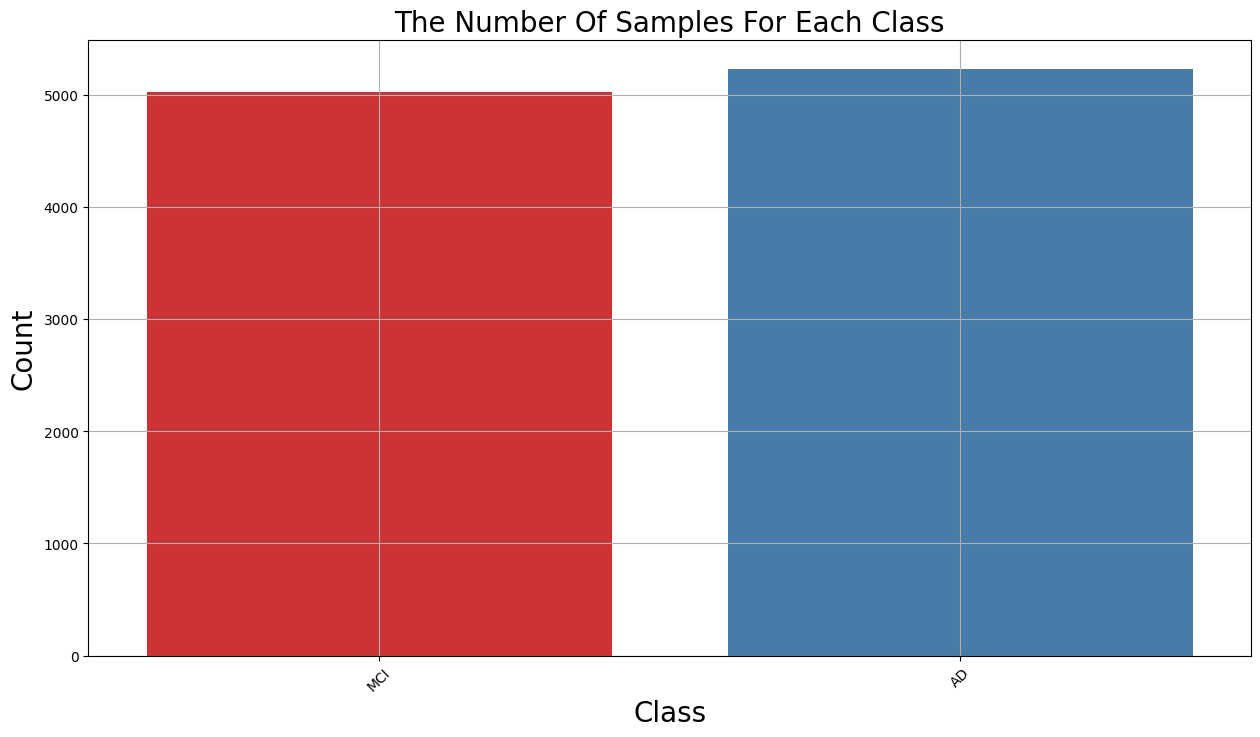

In [20]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Data Augmentation </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [21]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [22]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
#     rescale=1./255
#     horizontal_flip=True,
#     rotation_range=10,        # Utiliser une petite plage de rotation
#     width_shift_range=0.1,    # Décalage horizontal modéré
#     height_shift_range=0.1,   # Décalage vertical modéré
#     # shear_range=0.1,          # Cisaillement modéré
#     zoom_range=0.1,           # Zoom modéré
#     # brightness_range=[0.8, 1.2], # Variation de luminosité
#     fill_mode='nearest'       # Méthode de remplissage des pixels générés
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 8204 validated image filenames belonging to 2 classes.
Found 1026 validated image filenames belonging to 2 classes.
Found 1025 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

# Création du générateur de données sans prétraitement complexe
datagen = ImageDataGenerator(
    rescale=1./255  # Normalisation des valeurs des pixels entre 0 et 1
)

# Générateur pour l'entraînement
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Générateur pour le test
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Générateur pour la validation
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


In [ ]:
import matplotlib.pyplot as plt

# Obtenir une image du générateur
sample_image, _ = next(train_generator)

# Afficher l'image
plt.imshow(sample_image[5])
plt.show()


In [14]:
class_num=list(train_generator.class_indices.keys())
class_num

['AD', 'CN']

In [ ]:
from tensorflow.keras import layers, models

# Initialiser le modèle séquentiel
model = models.Sequential()

# Convolution Layer 1
model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 2
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(2, 2)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 5
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten pour passer aux couches entièrement connectées
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))

# Ajouter la couche de sortie pour la classification (par exemple, softmax pour 3 classes)
model.add(layers.Dense(2, activation='softmax'))

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


In [ ]:
checkpoint_cb =ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=15, restore_best_weights=True)
# model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

<a id="10"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">VGG16 Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [23]:
model = keras.models.Sequential()
model.add(tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet'))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Ajout de dropout après la première couche dense
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Ajout de dropout après la deuxième couche dense
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2, activation='softmax'))
model.layers[0].trainable = False
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 2048)              1050624   
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 1024)             

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Input
from tensorflow.keras.models import Model

# Charger le modèle VGG16 avec les poids pré-entraînés d'ImageNet
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet')

# Créez un modèle fonctionnel
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Assurez-vous que base_model ne soit pas en mode entraînement
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)

# Geler les poids du modèle VGG16 pré-entrainé
base_model.trainable = False

model.summary()


In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint pour sauvegarder les meilleurs poids
checkpoint_cb = ModelCheckpoint("model_VGG16.h5", save_best_only=True)

# Early stopping pour éviter le surapprentissage
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Scheduler pour réduire le taux d'apprentissage en cas de stagnation
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Compiler le modèle avec l'optimiseur Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les callbacks ajustés
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb])


In [ ]:
from tensorflow.keras.optimizers import SGD
# Using SGD optimizer with lower learning rate and momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)

checkpoint_cb = ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)  # Increase patience

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

In [24]:
checkpoint_cb =ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
257/257 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.7647

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


257/257 [==============================] - 64s 238ms/step - loss: 0.6331 - accuracy: 0.7647 - val_loss: 0.5555 - val_accuracy: 0.7200
Epoch 2/50
257/257 [==============================] - 41s 159ms/step - loss: 0.3329 - accuracy: 0.8569 - val_loss: 0.3162 - val_accuracy: 0.8585
Epoch 3/50
257/257 [==============================] - 39s 153ms/step - loss: 0.2514 - accuracy: 0.8982 - val_loss: 0.3232 - val_accuracy: 0.8702
Epoch 4/50
257/257 [==============================] - 40s 157ms/step - loss: 0.1888 - accuracy: 0.9256 - val_loss: 0.3391 - val_accuracy: 0.8615
Epoch 5/50
257/257 [==============================] - 40s 155ms/step - loss: 0.1551 - accuracy: 0.9381 - val_loss: 0.3880 - val_accuracy: 0.8605
Epoch 6/50
257/257 [==============================] - 40s 157ms/step - loss: 0.1218 - accuracy: 0.9517 - val_loss: 0.2963 - val_accuracy: 0.8995
Epoch 7/50
257/257 [==============================] - 41s 158ms/step - loss: 0.1040 - accuracy: 0.9578 - val_loss: 0.2483 - val_accuracy: 0.9

<a id="11"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [ ]:
model.save('/kaggle/working/modele_checkpoint.h5')
print("Le modèle a été sauvegardé sous le nom 'mon_modele.h5'")

In [25]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.633132,0.764749,0.555539,0.720000
1,0.332894,0.856899,0.316168,0.858537
2,0.251380,0.898220,0.323223,0.870244
3,0.188841,0.925646,0.339054,0.861463
4,0.155102,0.938079,0.388002,0.860488
5,0.121759,0.951731,0.296327,0.899512
6,0.104047,0.957825,0.248267,0.906341
7,0.099357,0.962214,0.345651,0.890732
8,0.090093,0.964651,0.241895,0.918049
9,0.060075,0.980132,0.253352,0.920000


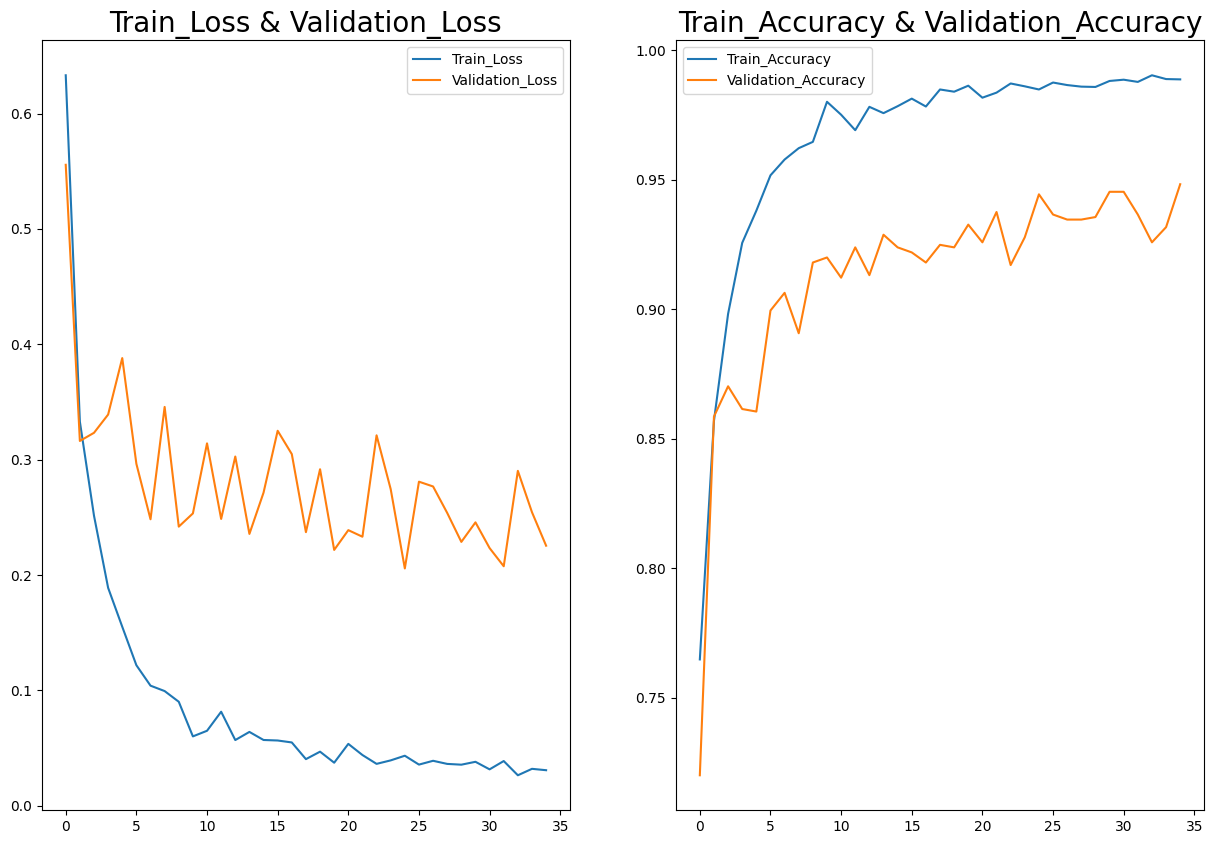

In [33]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [27]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

33/33 [==============================] - 9s 258ms/step - loss: 0.2283 - accuracy: 0.9376
Test Loss = 0.228313148021698
Test Accuracy = 0.9376218318939209


In [29]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

33/33 [==============================] - 4s 123ms/step


,Actual,Prediction
0,1,1
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
1021,0,0
1022,1,1
1023,1,1
1024,0,0


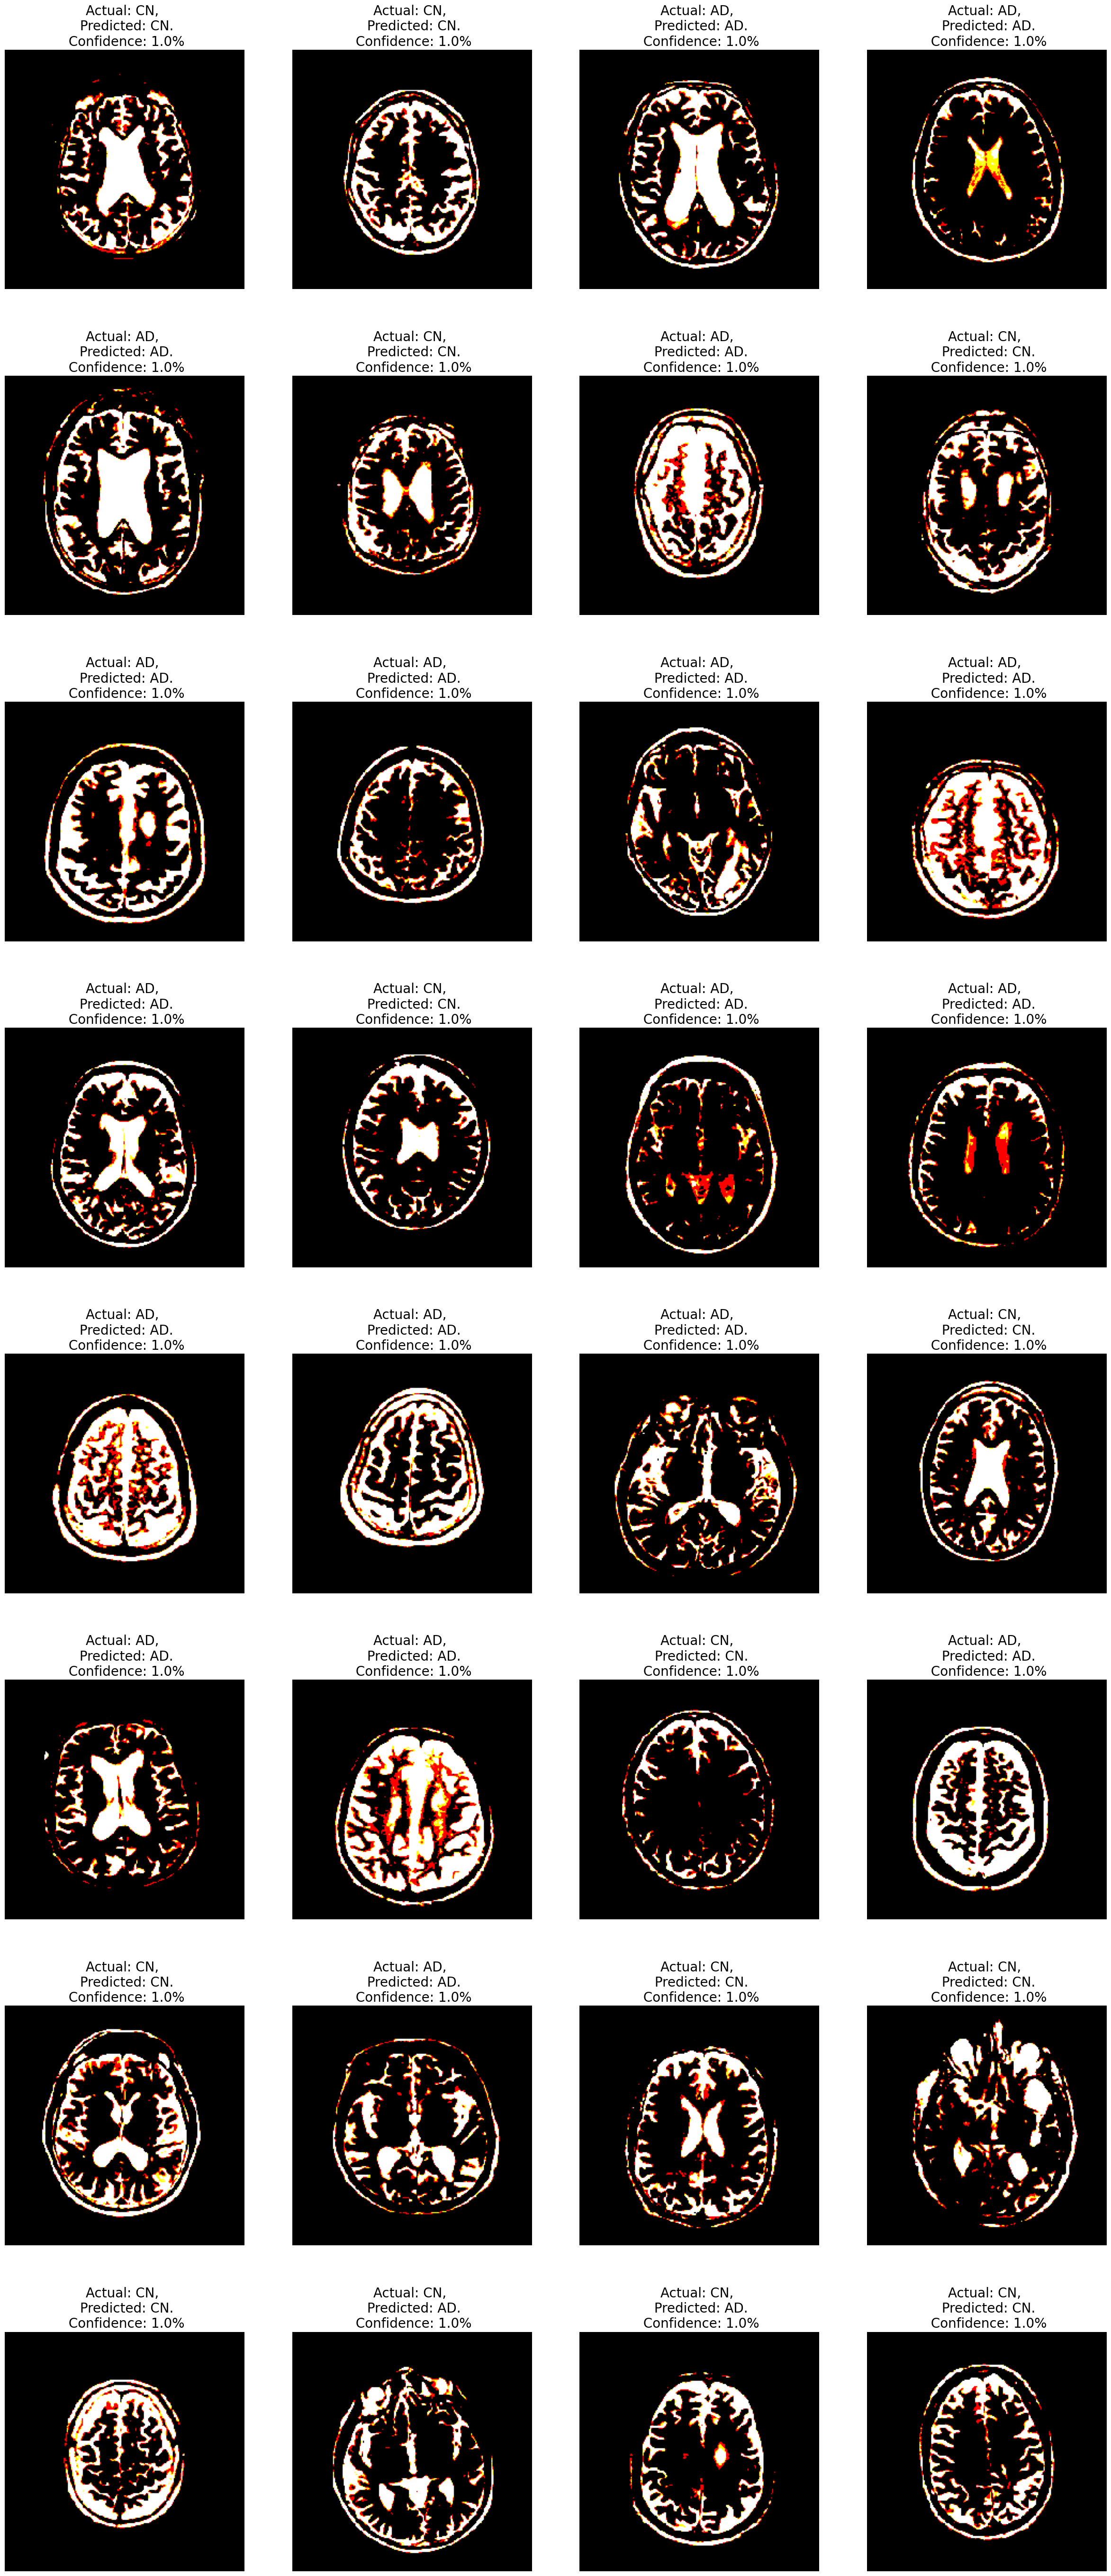

In [30]:
plt.figure(figsize=(30,70))
batch = next(test_generator)
images= batch[0]
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.\n Confidence: {round(predictions[n][np.argmax(predictions[n])],0)}%",fontsize=20)

array([[495,  28],
       [ 36, 467]])

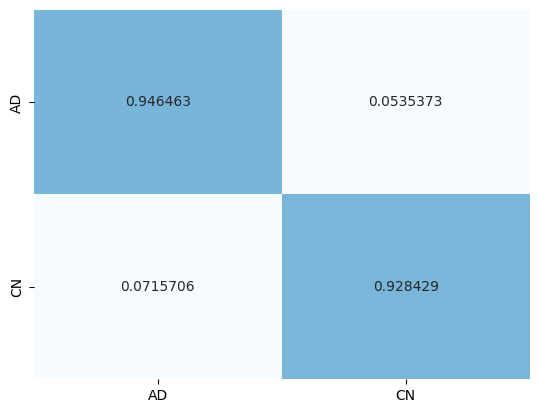

In [31]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [34]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                precision    recall  f1-score   support

          AD       0.93      0.95      0.94       523
          CN       0.94      0.93      0.94       503

    accuracy                           0.94      1026
   macro avg       0.94      0.94      0.94      1026
weighted avg       0.94      0.94      0.94      1026

